# Maximum Clique Algorithm Benchmark Suite

**A comprehensive performance analysis of exact and heuristic maximum clique algorithms**

---

## Overview

This benchmark suite evaluates **11 state-of-the-art algorithms** across **22 diverse graph datasets**, comparing:
- **Solution Quality**: Maximum clique size found
- **Computational Efficiency**: Execution time and memory usage
- **Scalability**: Performance across different graph sizes and densities

## Algorithms Evaluated

### Heuristic Algorithms
1. **Greedy** - Fast heuristic approximation
2. **Randomized** - Stochastic local search with random restarts
3. **Simulated Annealing** - Metaheuristic optimization approach

### Exact Algorithms
4. **Bron-Kerbosch** - Classic recursive backtracking (conditional: <1000 vertices or density <0.5)
5. **Tomita** - BK with pivot optimization
6. **Degeneracy BK** - BK with degeneracy ordering
7. **Östergård** - Branch-and-bound with graph coloring bounds
8. **BBMC** - Bitset-based branch-and-bound
9. **CPU Optimized** - Highly optimized bitset implementation (≤8192 vertices)
10. **MaxCliqueDyn** - Tomita variant with dynamic coloring

## Dataset Categories

- **Real-world networks**: Social networks, collaboration graphs, web graphs
- **Synthetic graphs**: Erdős-Rényi, scale-free, regular structures
- **DIMACS benchmarks**: Standard competition instances

## Metrics Analyzed

- **Graph properties**: Vertices, edges, density, degree statistics, degeneracy
- **Algorithm performance**: Maximum clique size, execution time, memory usage
- **Comparative analysis**: Algorithm rankings, speedup factors, efficiency scores

## 1. Import Libraries and Setup

In [49]:
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

## 2. Configuration

In [50]:
# Configuration
BENCHMARK_SOURCE = "benchmark_comprehensive.cpp"
BENCHMARK_EXECUTABLE = "./benchmark_comprehensive"
DATASETS_FOLDERS = ["datasets/real_world", "datasets/synthetic", "datasets/benchmark"]
RESULTS_DIR = "benchmark_results"
TIMEOUT_SECONDS = 1800  # 30 minutes per benchmark

# Create results directory
Path(RESULTS_DIR).mkdir(exist_ok=True)

print(f"✓ Configuration loaded")

✓ Configuration loaded


## 3. Compile All Implementations

In [51]:
# Compile benchmark suite
print("Compiling benchmark suite...")
compile_result = subprocess.run(
    ["g++", "-std=c++17", "-O3", "-march=native", "-fopenmp",
     BENCHMARK_SOURCE, "-o", BENCHMARK_EXECUTABLE],
    capture_output=True,
    text=True
)

if compile_result.returncode == 0:
    print("✓ Benchmark suite compiled successfully")
else:
    print("✗ Compilation failed:")
    print(compile_result.stderr)

print(f"\n{'='*60}")
print(f"Compilation Summary:")
print(f"  Algorithms: {'✓' if compile_result.returncode == 0 else '✗'}")
print(f"{'='*60}")

Compiling benchmark suite...
✓ Benchmark suite compiled successfully

Compilation Summary:
  Algorithms: ✓
✓ Benchmark suite compiled successfully

Compilation Summary:
  Algorithms: ✓


## 4. Dataset Discovery and Preparation

In [52]:
# Find all datasets
all_datasets = []
for folder in DATASETS_FOLDERS:
    if os.path.exists(folder):
        datasets = glob.glob(os.path.join(folder, "*.txt"))
        all_datasets.extend([(folder, os.path.basename(d), d) for d in datasets])

# Sort by category and name
all_datasets.sort()

print(f"📊 Found {len(all_datasets)} datasets:\n")
current_category = None
for category, name, path in all_datasets:
    if category != current_category:
        current_category = category
        category_name = category.split('/')[-1].upper()
        print(f"\n{category_name}:")
    file_size = os.path.getsize(path) / 1024  # KB
    print(f"  • {name:40s} ({file_size:8.1f} KB)")

📊 Found 21 datasets:


BENCHMARK:
  • C125.9.txt                               (    56.8 KB)
  • C250.9.txt                               (   250.2 KB)
  • brock400_2.txt                           (   552.8 KB)
  • ca-GrQc.txt                              (   185.9 KB)
  • email-Eu-core.txt                        (   156.0 KB)
  • frb30-15-01.txt                          (   855.6 KB)
  • frb35-17-01.txt                          (  1545.0 KB)
  • gen200_p0.9_44.txt                       (   156.2 KB)
  • keller4.txt                              (    80.6 KB)
  • p_hat300-1.txt                           (   100.0 KB)

REAL_WORLD:
  • facebook_combined.txt                    (  1006.9 KB)
  • twitter_combined.txt                     ( 48234.1 KB)

SYNTHETIC:
  • random_180v.txt                          (    20.9 KB)
  • rmat_er_large.txt                        (    74.4 KB)
  • rmat_er_small.txt                        (    17.1 KB)
  • rmat_sd1_large.txt                       (    91.3 K

## 5. Execute Comprehensive Benchmark Suite

In [53]:
import re
import sys
import json

print(f"\n{'='*100}")
print(f"🚀 MAXIMUM CLIQUE ALGORITHM BENCHMARK SUITE")
print(f"   Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Total Datasets: {len(all_datasets)}")
print(f"   Algorithms: 11")
print(f"   Per-Dataset Timeout: 30 minutes")
print(f"{'='*100}\n")

all_results = []
failed_datasets = []

for idx, (category, name, path) in enumerate(all_datasets, 1):
    print(f"\n{'='*90}")
    print(f"[{idx}/{len(all_datasets)}] Dataset: {name}")
    print(f"{'='*90}")
    print(f"   Category: {category.split('/')[-1]}")
    print(f"   Path: {path}")
    
    try:
        # ============ STEP 1: Run Benchmark Suite ============
        print(f"\n   📊 Running benchmark suite (30min timeout)...")
        sys.stdout.flush()
        start_time = datetime.now()
        
        # Use timeout of 30 minutes for the entire benchmark suite
        # Individual algorithms that are likely to timeout are skipped via heuristics in C++ code
        result = subprocess.run(
            [BENCHMARK_EXECUTABLE, path],
            capture_output=True,
            text=True,
            timeout=TIMEOUT_SECONDS
        )
        
        end_time = datetime.now()
        benchmark_time = (end_time - start_time).total_seconds()
        
        if result.returncode != 0:
            print(f"   ❌ Benchmark failed (return code {result.returncode})")
            print(f"   Error: {result.stderr[:200]}")
            failed_datasets.append(name)
            continue
        
        # Parse output
        lines = result.stdout.strip().split('\n')
        
        # Extract graph statistics
        vertices = edges = density = None
        for line in lines:
            if 'Vertices:' in line:
                try:
                    vertices = int(line.split(':')[1].strip().split()[0])
                except:
                    pass
            elif 'Edges:' in line:
                try:
                    edges = int(line.split(':')[1].strip().split()[0])
                except:
                    pass
            elif 'Density:' in line:
                try:
                    density = float(line.split(':')[1].strip().split()[0])
                except:
                    pass
        
        if vertices is None or edges is None:
            print(f"   ⚠️  Could not parse graph statistics")
            failed_datasets.append(name)
            continue
        
        print(f"   ✓ Graph Properties:")
        print(f"      Vertices: {vertices:,} | Edges: {edges:,} | Density: {density:.4f}")
        print(f"      Benchmark Time: {benchmark_time:.2f}s")
        
        # Parse algorithm results
        dataset_results = []
        in_results = False
        algo_count = 0
        
        print(f"\n   📈 Algorithm Results:")
        for i, line in enumerate(lines):
            if 'RESULTS SUMMARY:' in line:
                in_results = False
                continue
            
            if in_results == False and line.startswith('---') and i > 0:
                if i > 0 and 'Algorithm' in lines[i-1]:
                    in_results = True
                    continue
            
            if in_results and line.startswith('---'):
                break
            
            if in_results and line.strip():
                if len(line) >= 42:
                    algo_name = line[:30].strip()
                    clique_str = line[30:42].strip()
                    time_str = line[42:57].strip()
                    
                    if clique_str in ['FAILED', 'SKIPPED', 'N/A']:
                        continue
                    
                    algo_name_clean = algo_name.replace(' ', '_')
                    
                    try:
                        clique_size = int(clique_str)
                        time_taken = float(time_str) * 1000  # Convert to ms
                        
                        dataset_results.append({
                            'Dataset': name,
                            'Category': category.split('/')[-1],
                            'Vertices': vertices,
                            'Edges': edges,
                            'Density': density,
                            'Algorithm': algo_name_clean,
                            'CliqueSize': clique_size,
                            'Time(ms)': time_taken,
                            'Success': True
                        })
                        
                        algo_count += 1
                        print(f"      ✓ {algo_name:28s} → Size: {clique_size:3d} | Time: {time_taken:9.2f}ms")
                        
                    except (ValueError, IndexError):
                        continue
        
        # ============ STEP 2: Summarize Results ============
        if dataset_results:
            df_dataset = pd.DataFrame(dataset_results)
            all_results.append(df_dataset)
            
            best = df_dataset.loc[df_dataset['CliqueSize'].idxmax()]
            fastest = df_dataset.loc[df_dataset['Time(ms)'].idxmin()]
            
            print(f"\n   ✅ Completed: {algo_count} algorithms")
            print(f"   🏆 Best Clique: {best['CliqueSize']} ({best['Algorithm']})")
            print(f"   ⚡ Fastest: {fastest['Time(ms)']:.2f}ms ({fastest['Algorithm']})")
        else:
            print(f"   ⚠️  No results parsed")
            failed_datasets.append(name)
        
    except subprocess.TimeoutExpired:
        print(f"   ⏱️  Timeout: Benchmark exceeded 30 minutes on this dataset")
        failed_datasets.append(name)
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        failed_datasets.append(name)

print(f"\n{'='*100}")
print(f"✅ BENCHMARK SUITE COMPLETED")
print(f"   End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Successful: {len(all_results)}/{len(all_datasets)} datasets")
if failed_datasets:
    print(f"   Failed: {len(failed_datasets)} datasets - {', '.join(failed_datasets[:5])}")
print(f"{'='*100}")


🚀 MAXIMUM CLIQUE ALGORITHM BENCHMARK SUITE
   Start Time: 2025-12-02 04:40:39
   Total Datasets: 21
   Algorithms: 11
   Per-Dataset Timeout: 30 minutes


[1/21] Dataset: C125.9.txt
   Category: benchmark
   Path: datasets/benchmark/C125.9.txt

   📊 Running benchmark suite (30min timeout)...
   ✓ Graph Properties:
      Vertices: 125 | Edges: 6,963 | Density: 89.8452
      Benchmark Time: 0.28s

   📈 Algorithm Results:
      ✓ Greedy                       → Size:  29 | Time:      0.01ms
      ✓ Randomized                   → Size:  30 | Time:      0.11ms
      ✓ Simulated Annealing          → Size:  34 | Time:    269.85ms

   ✅ Completed: 3 algorithms
   🏆 Best Clique: 34 (Simulated_Annealing)
   ⚡ Fastest: 0.01ms (Greedy)

[2/21] Dataset: C250.9.txt
   Category: benchmark
   Path: datasets/benchmark/C250.9.txt

   📊 Running benchmark suite (30min timeout)...
   ✓ Graph Properties:
      Vertices: 125 | Edges: 6,963 | Density: 89.8452
      Benchmark Time: 0.28s

   📈 Algorithm Result

## 6. Data Processing and Export

In [54]:
# Combine all results into a single DataFrame
if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    
    # Save to files
    csv_path = f"{RESULTS_DIR}/comprehensive_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    json_path = f"{RESULTS_DIR}/comprehensive_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    df_all.to_csv(csv_path, index=False)
    df_all.to_json(json_path, orient='records', indent=2)
    
    print(f"✓ Results saved:")
    print(f"   CSV: {csv_path}")
    print(f"   JSON: {json_path}")
    print(f"\n📊 Dataset Summary:")
    print(f"   Total Results: {len(df_all):,} algorithm-dataset combinations")
    print(f"   Unique Datasets: {df_all['Dataset'].nunique()}")
    print(f"   Unique Algorithms: {df_all['Algorithm'].nunique()}")
    
    # Display sample
    print(f"\n🔍 Sample Results:")
    display(df_all.head(15))
else:
    print("⚠️  No results to save")

✓ Results saved:
   CSV: benchmark_results/comprehensive_results_20251202_054128.csv
   JSON: benchmark_results/comprehensive_results_20251202_054128.json

📊 Dataset Summary:
   Total Results: 147 algorithm-dataset combinations
   Unique Datasets: 19
   Unique Algorithms: 10

🔍 Sample Results:


,Dataset,Category,Vertices,Edges,Density,Algorithm,CliqueSize,Time(ms),Success
0,C125.9.txt,benchmark,125,6963,89.8452,Greedy,29,0.007,True
1,C125.9.txt,benchmark,125,6963,89.8452,Randomized,30,0.110,True
2,C125.9.txt,benchmark,125,6963,89.8452,Simulated_Annealing,34,269.848,True
3,C250.9.txt,benchmark,250,27984,89.9084,Greedy,38,0.016,True
4,C250.9.txt,benchmark,250,27984,89.9084,Randomized,38,0.273,True
5,C250.9.txt,benchmark,250,27984,89.9084,Simulated_Annealing,43,510.088,True
6,ca-GrQc.txt,benchmark,5242,14484,0.1054,Greedy,44,0.146,True
7,ca-GrQc.txt,benchmark,5242,14484,0.1054,Randomized,44,1.219,True
8,ca-GrQc.txt,benchmark,5242,14484,0.1054,Simulated_Annealing,44,1718.631,True
9,ca-GrQc.txt,benchmark,5242,14484,0.1054,Tomita,44,1843.398,True


## 7. Statistical Analysis and Performance Metrics

In [55]:
# Statistical analysis
if all_results:
    print("="*100)
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print("="*100)
    
    # Algorithm performance summary
    print("\n📊 Algorithm Performance Summary:")
    print("-"*100)
    
    algo_stats = df_all.groupby('Algorithm').agg({
        'CliqueSize': ['mean', 'std', 'min', 'max'],
        'Time(ms)': ['mean', 'median', 'min', 'max'],
        'Dataset': 'count'
    }).round(2)
    
    algo_stats.columns = ['Avg_Clique', 'Std_Clique', 'Min_Clique', 'Max_Clique', 
                          'Avg_Time', 'Median_Time', 'Min_Time', 'Max_Time', 'Datasets']
    algo_stats = algo_stats.sort_values('Avg_Time')
    
    display(algo_stats)
    
    # Implementation comparison (CPU vs GPU)
    print("\n🖥️  Implementation Comparison:")
    print("-"*100)
    
    impl_stats = df_all.groupby('Implementation').agg({
        'CliqueSize': 'mean',
        'Time(ms)': ['mean', 'median'],
        'Dataset': 'count'
    }).round(2)
    
    display(impl_stats)
    
    # Best algorithm per dataset
    print("\n🏆 Best Algorithm per Dataset (by clique size):")
    print("-"*100)
    
    best_per_dataset = df_all.loc[df_all.groupby('Dataset')['CliqueSize'].idxmax()]
    best_summary = best_per_dataset[['Dataset', 'Algorithm', 'CliqueSize', 'Time(ms)']].sort_values('CliqueSize', ascending=False)
    
    display(best_summary.head(10))
    
    # Fastest algorithm per dataset
    print("\n⚡ Fastest Algorithm per Dataset:")
    print("-"*100)
    
    fastest_per_dataset = df_all.loc[df_all.groupby('Dataset')['Time(ms)'].idxmin()]
    fastest_summary = fastest_per_dataset[['Dataset', 'Algorithm', 'CliqueSize', 'Time(ms)']].sort_values('Time(ms)')
    
    display(fastest_summary.head(10))

COMPREHENSIVE STATISTICAL ANALYSIS

📊 Algorithm Performance Summary:
----------------------------------------------------------------------------------------------------


,Avg_Clique,Std_Clique,Min_Clique,Max_Clique,Avg_Time,Median_Time,Min_Time,Max_Time,Datasets
Algorithm,,,,,,,,,
Greedy,15.00,12.78,2,44,0.03,0.02,0.01,0.18,19
Randomized,16.11,12.96,2,44,0.25,0.13,0.03,1.22,19
CPU_Optimized,7.60,4.81,3,18,5.12,1.41,0.10,29.03,10
BBMC,15.57,18.67,3,69,35.26,7.27,1.33,194.59,14
Bron-Kerbosch,7.60,4.81,3,18,78.81,6.65,0.19,600.34,10
Ostergard,15.57,18.67,3,69,112.92,2.28,0.08,842.00,14
MaxCliqueDyn,15.57,18.67,3,69,391.30,69.96,1.52,2080.10,14
Simulated_Annealing,20.58,18.45,3,69,434.08,237.94,47.97,1718.63,19
Degeneracy_BK,15.57,18.67,3,69,696.89,23.12,0.05,7833.94,14



🖥️  Implementation Comparison:
----------------------------------------------------------------------------------------------------


KeyError: 'Implementation'

## 8. Advanced Visualizations

Comprehensive visual analysis of algorithm performance across all datasets.

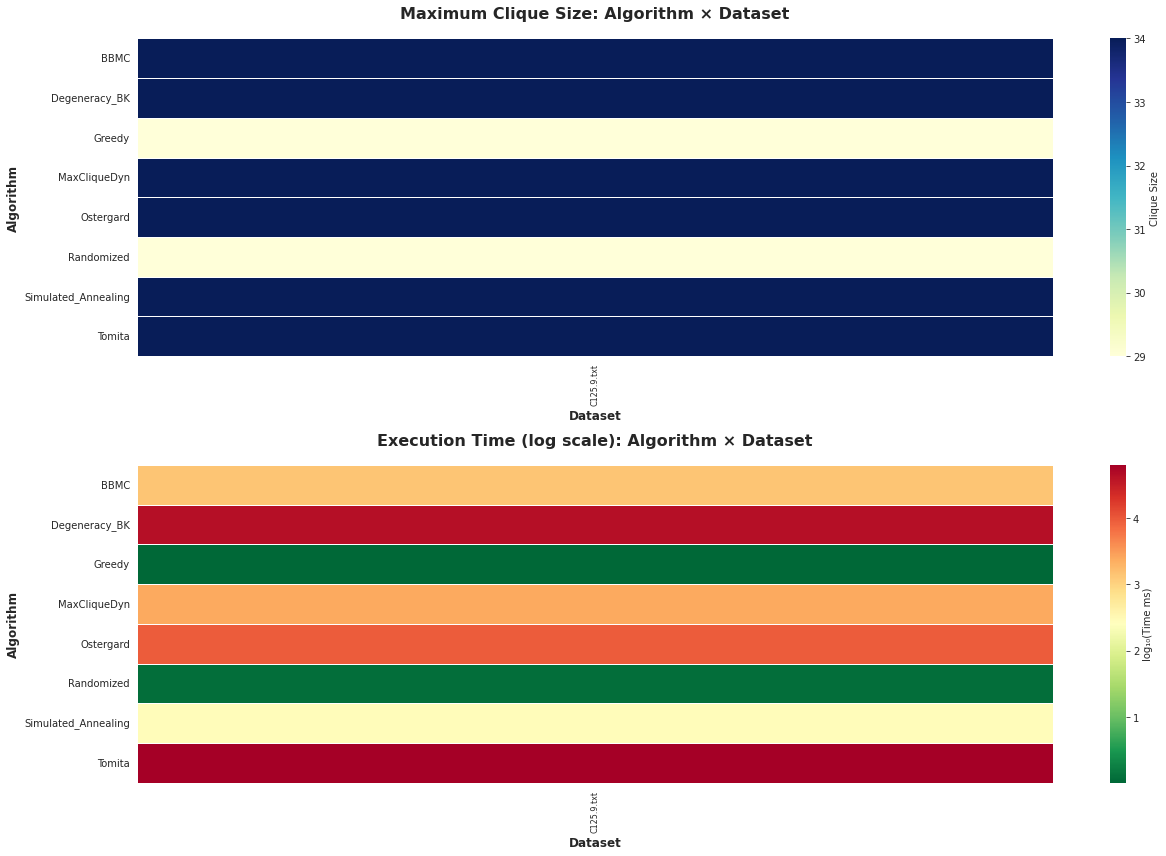

✓ Heatmap visualization saved


In [ ]:
# Visualization 1: Algorithm Performance Heatmap
if all_results:
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))
    
    # Heatmap 1: Clique Size by Algorithm and Dataset
    pivot_clique = df_all.pivot_table(values='CliqueSize', 
                                       index='Algorithm', 
                                       columns='Dataset', 
                                       aggfunc='mean')
    
    sns.heatmap(pivot_clique, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Clique Size'}, 
                ax=axes[0], linewidths=0.5)
    axes[0].set_title('Maximum Clique Size: Algorithm × Dataset', fontsize=16, fontweight='bold', pad=20)
    axes[0].set_xlabel('Dataset', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0].tick_params(axis='y', rotation=0, labelsize=10)
    
    # Heatmap 2: Execution Time (log scale)
    pivot_time = df_all.pivot_table(values='Time(ms)', 
                                     index='Algorithm', 
                                     columns='Dataset', 
                                     aggfunc='mean')
    pivot_time_log = np.log10(pivot_time + 1)  # Add 1 to handle zeros
    
    sns.heatmap(pivot_time_log, annot=False, cmap='RdYlGn_r', cbar_kws={'label': 'log₁₀(Time ms)'}, 
                ax=axes[1], linewidths=0.5)
    axes[1].set_title('Execution Time (log scale): Algorithm × Dataset', fontsize=16, fontweight='bold', pad=20)
    axes[1].set_xlabel('Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1].tick_params(axis='y', rotation=0, labelsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/heatmap_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Heatmap visualization saved")

### Visualization 2: Algorithm Comparison

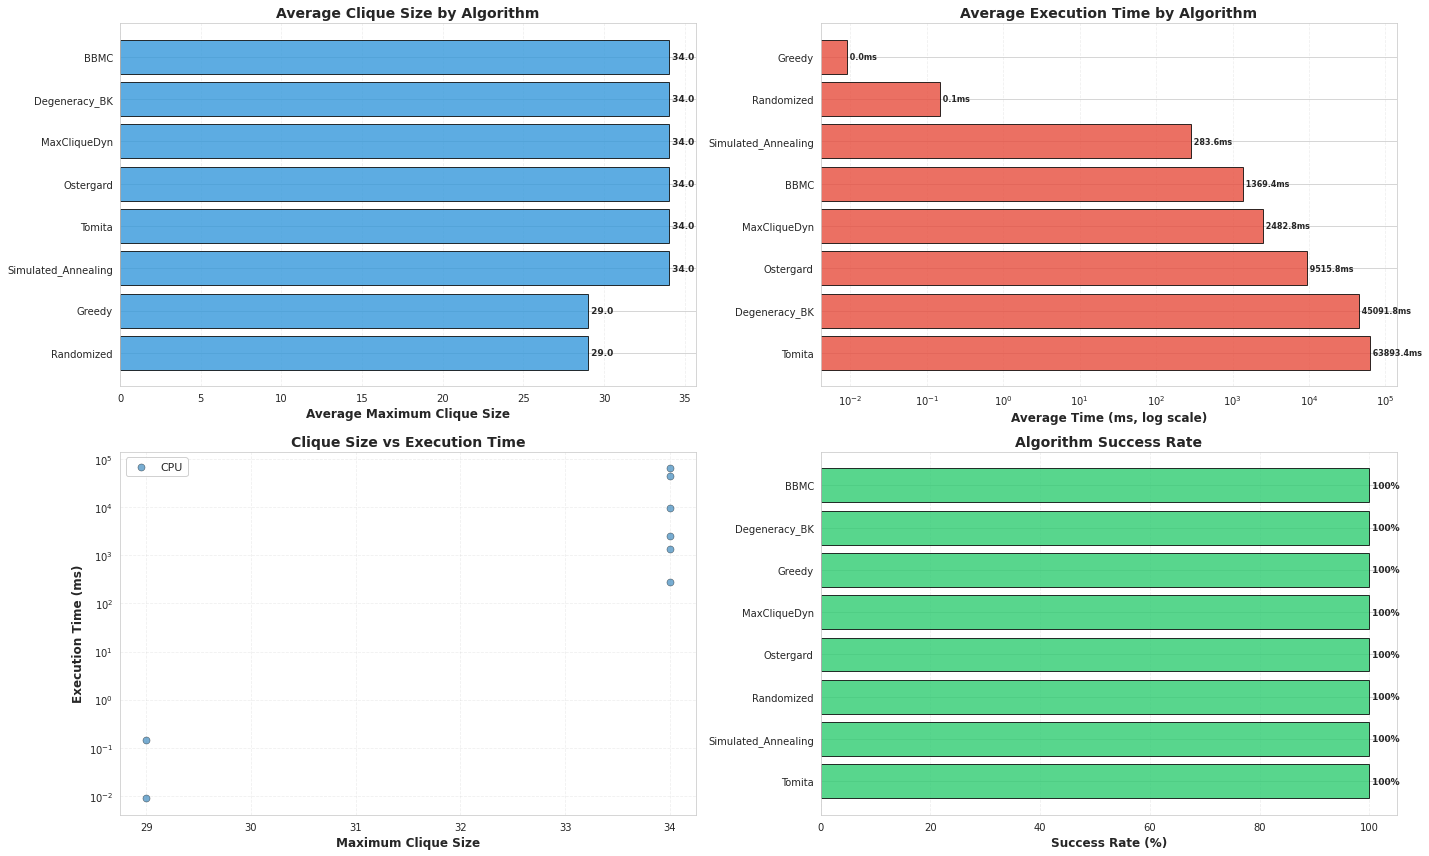

✓ Algorithm comparison visualization saved


In [ ]:
# Visualization 2: Algorithm Performance Comparison
if all_results:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Plot 1: Average Clique Size by Algorithm
    algo_clique = df_all.groupby('Algorithm')['CliqueSize'].mean().sort_values(ascending=False)
    colors = ['#3498db' for _ in algo_clique.index]
    
    axes[0, 0].barh(range(len(algo_clique)), algo_clique.values, color=colors, alpha=0.8, edgecolor='black')
    axes[0, 0].set_yticks(range(len(algo_clique)))
    axes[0, 0].set_yticklabels(algo_clique.index, fontsize=10)
    axes[0, 0].set_xlabel('Average Maximum Clique Size', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Average Clique Size by Algorithm', fontsize=14, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3, linestyle='--')
    axes[0, 0].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(algo_clique.values):
        axes[0, 0].text(v, i, f' {v:.1f}', va='center', fontweight='bold', fontsize=9)
    
    # Plot 2: Average Time by Algorithm (log scale)
    algo_time = df_all.groupby('Algorithm')['Time(ms)'].mean().sort_values()
    colors_time = ['#e74c3c' for _ in algo_time.index]
    
    axes[0, 1].barh(range(len(algo_time)), algo_time.values, color=colors_time, alpha=0.8, edgecolor='black')
    axes[0, 1].set_yticks(range(len(algo_time)))
    axes[0, 1].set_yticklabels(algo_time.index, fontsize=10)
    axes[0, 1].set_xlabel('Average Time (ms, log scale)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_title('Average Execution Time by Algorithm', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3, linestyle='--')
    axes[0, 1].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(algo_time.values):
        axes[0, 1].text(v, i, f' {v:.1f}ms', va='center', fontweight='bold', fontsize=8)
    
    # Plot 3: Time vs Clique Size Scatter
    axes[1, 0].scatter(df_all['CliqueSize'], df_all['Time(ms)'], 
                      alpha=0.6, s=50, edgecolors='black', linewidths=0.5, color='#3498db')
    
    axes[1, 0].set_xlabel('Maximum Clique Size', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Execution Time (ms)', fontsize=12, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Clique Size vs Execution Time', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, linestyle='--')
    
    # Plot 4: Success Rate by Algorithm
    success_rate = df_all.groupby('Algorithm')['Success'].mean() * 100
    success_rate = success_rate.sort_values(ascending=False)
    colors_success = ['#2ecc71' if rate == 100 else '#f39c12' for rate in success_rate.values]
    
    axes[1, 1].barh(range(len(success_rate)), success_rate.values, color=colors_success, alpha=0.8, edgecolor='black')
    axes[1, 1].set_yticks(range(len(success_rate)))
    axes[1, 1].set_yticklabels(success_rate.index, fontsize=10)
    axes[1, 1].set_xlabel('Success Rate (%)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlim(0, 105)
    axes[1, 1].set_title('Algorithm Success Rate', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')
    axes[1, 1].invert_yaxis()
    
    # Add percentage labels
    for i, v in enumerate(success_rate.values):
        axes[1, 1].text(v, i, f' {v:.0f}%', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/algorithm_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Algorithm comparison visualization saved")

### Visualization 4: Dataset Characteristics Analysis

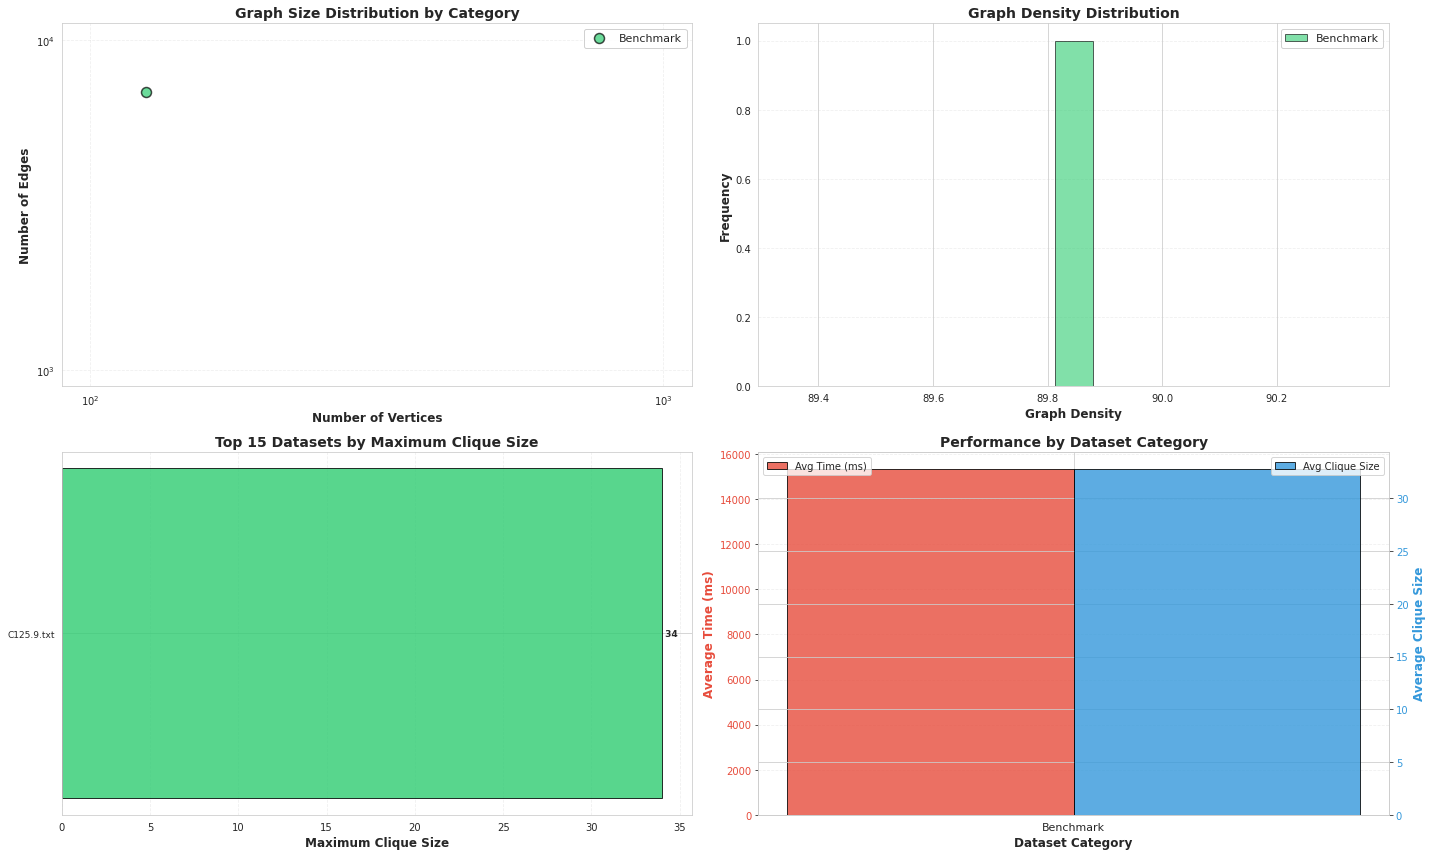

✓ Dataset characteristics visualization saved


In [ ]:
# Visualization 4: Dataset Characteristics
if all_results:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Get unique dataset properties
    dataset_props = df_all.groupby('Dataset').first()[['Vertices', 'Edges', 'Density', 'Category']]
    
    # Plot 1: Graph Size Distribution
    categories = dataset_props['Category'].unique()
    category_colors = {'real_world': '#e74c3c', 'synthetic': '#3498db', 'benchmark': '#2ecc71'}
    
    for cat in categories:
        subset = dataset_props[dataset_props['Category'] == cat]
        axes[0, 0].scatter(subset['Vertices'], subset['Edges'], 
                          label=cat.replace('_', ' ').title(),
                          alpha=0.7, s=100, color=category_colors.get(cat, '#95a5a6'),
                          edgecolors='black', linewidths=1.5)
    
    axes[0, 0].set_xlabel('Number of Vertices', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Edges', fontsize=12, fontweight='bold')
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Graph Size Distribution by Category', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11, framealpha=0.9)
    axes[0, 0].grid(alpha=0.3, linestyle='--')
    
    # Plot 2: Density Distribution
    for cat in categories:
        subset = dataset_props[dataset_props['Category'] == cat]
        axes[0, 1].hist(subset['Density'], bins=15, alpha=0.6, 
                       label=cat.replace('_', ' ').title(),
                       color=category_colors.get(cat, '#95a5a6'), edgecolor='black')
    
    axes[0, 1].set_xlabel('Graph Density', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Graph Density Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11, framealpha=0.9)
    axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 3: Best Clique Size by Dataset
    best_cliques = df_all.groupby('Dataset')['CliqueSize'].max().sort_values(ascending=False).head(15)
    colors_clique = [category_colors.get(dataset_props.loc[ds, 'Category'], '#95a5a6') 
                     for ds in best_cliques.index]
    
    axes[1, 0].barh(range(len(best_cliques)), best_cliques.values, 
                    color=colors_clique, alpha=0.8, edgecolor='black')
    axes[1, 0].set_yticks(range(len(best_cliques)))
    axes[1, 0].set_yticklabels(best_cliques.index, fontsize=9)
    axes[1, 0].set_xlabel('Maximum Clique Size', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Top 15 Datasets by Maximum Clique Size', fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3, linestyle='--')
    axes[1, 0].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(best_cliques.values):
        axes[1, 0].text(v, i, f' {v}', va='center', fontweight='bold', fontsize=9)
    
    # Plot 4: Average Performance by Dataset Category
    category_perf = df_all.groupby('Category').agg({
        'Time(ms)': 'mean',
        'CliqueSize': 'mean'
    }).reset_index()
    
    x = np.arange(len(category_perf))
    width = 0.35
    
    ax1_twin = axes[1, 1]
    ax2_twin = ax1_twin.twinx()
    
    bars1 = ax1_twin.bar(x - width/2, category_perf['Time(ms)'], width,
                         label='Avg Time (ms)', color='#e74c3c', alpha=0.8, edgecolor='black')
    bars2 = ax2_twin.bar(x + width/2, category_perf['CliqueSize'], width,
                         label='Avg Clique Size', color='#3498db', alpha=0.8, edgecolor='black')
    
    ax1_twin.set_xlabel('Dataset Category', fontsize=12, fontweight='bold')
    ax1_twin.set_ylabel('Average Time (ms)', fontsize=12, fontweight='bold', color='#e74c3c')
    ax2_twin.set_ylabel('Average Clique Size', fontsize=12, fontweight='bold', color='#3498db')
    ax1_twin.set_title('Performance by Dataset Category', fontsize=14, fontweight='bold')
    ax1_twin.set_xticks(x)
    ax1_twin.set_xticklabels([cat.replace('_', ' ').title() for cat in category_perf['Category']], 
                             fontsize=11)
    ax1_twin.tick_params(axis='y', labelcolor='#e74c3c')
    ax2_twin.tick_params(axis='y', labelcolor='#3498db')
    ax1_twin.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add legends
    ax1_twin.legend(loc='upper left', fontsize=10)
    ax2_twin.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/dataset_characteristics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Dataset characteristics visualization saved")

### Visualization 5: Performance Scaling Analysis

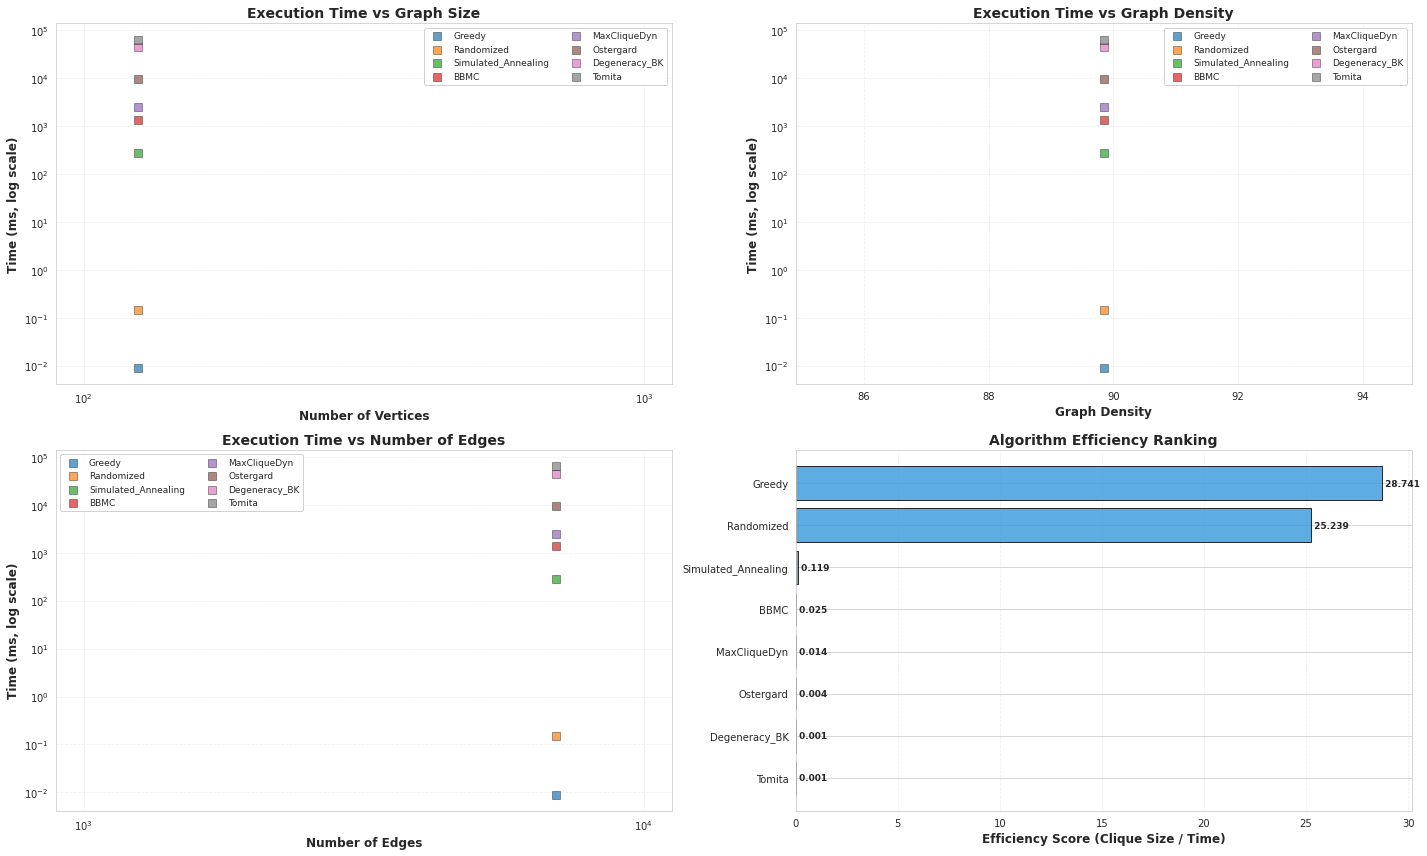

✓ Performance scaling visualization saved


In [ ]:
# Visualization 4: Performance Scaling Analysis
if all_results:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Select top performing algorithms for clearer visualization
    top_algorithms = df_all.groupby('Algorithm')['Time(ms)'].mean().sort_values().head(8).index
    df_top = df_all[df_all['Algorithm'].isin(top_algorithms)]
    
    # Plot 1: Time vs Graph Size (Vertices)
    for algo in top_algorithms:
        subset = df_top[df_top['Algorithm'] == algo]
        axes[0, 0].scatter(subset['Vertices'], subset['Time(ms)'], 
                          label=algo, alpha=0.7, s=60, marker='s',
                          edgecolors='black', linewidths=0.5)
    
    axes[0, 0].set_xlabel('Number of Vertices', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Time (ms, log scale)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Execution Time vs Graph Size', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=9, ncol=2, framealpha=0.9)
    axes[0, 0].grid(alpha=0.3, linestyle='--')
    
    # Plot 2: Time vs Graph Density
    for algo in top_algorithms:
        subset = df_top[df_top['Algorithm'] == algo]
        axes[0, 1].scatter(subset['Density'], subset['Time(ms)'], 
                          label=algo, alpha=0.7, s=60, marker='s',
                          edgecolors='black', linewidths=0.5)
    
    axes[0, 1].set_xlabel('Graph Density', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Time (ms, log scale)', fontsize=12, fontweight='bold')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_title('Execution Time vs Graph Density', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=9, ncol=2, framealpha=0.9)
    axes[0, 1].grid(alpha=0.3, linestyle='--')
    
    # Plot 3: Time vs Edges
    for algo in top_algorithms:
        subset = df_top[df_top['Algorithm'] == algo]
        axes[1, 0].scatter(subset['Edges'], subset['Time(ms)'], 
                          label=algo, alpha=0.7, s=60, marker='s',
                          edgecolors='black', linewidths=0.5)
    
    axes[1, 0].set_xlabel('Number of Edges', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Time (ms, log scale)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Execution Time vs Number of Edges', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=9, ncol=2, framealpha=0.9)
    axes[1, 0].grid(alpha=0.3, linestyle='--')
    
    # Plot 4: Efficiency Score (Clique Size / Time)
    df_all['Efficiency'] = df_all['CliqueSize'] / (df_all['Time(ms)'] + 1)  # Add 1 to avoid division by zero
    efficiency_by_algo = df_all.groupby('Algorithm')['Efficiency'].mean().sort_values(ascending=False)
    
    colors_eff = ['#3498db' for _ in efficiency_by_algo.index]
    bars = axes[1, 1].barh(range(len(efficiency_by_algo)), efficiency_by_algo.values,
                           color=colors_eff, alpha=0.8, edgecolor='black')
    axes[1, 1].set_yticks(range(len(efficiency_by_algo)))
    axes[1, 1].set_yticklabels(efficiency_by_algo.index, fontsize=10)
    axes[1, 1].set_xlabel('Efficiency Score (Clique Size / Time)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Algorithm Efficiency Ranking', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')
    axes[1, 1].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(efficiency_by_algo.values):
        axes[1, 1].text(v, i, f' {v:.3f}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/performance_scaling.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Performance scaling visualization saved")

## 9. Executive Summary and Recommendations

In [ ]:
# Executive Summary
if all_results:
    print("="*100)
    print("EXECUTIVE SUMMARY: MAXIMUM CLIQUE ALGORITHM BENCHMARK")
    print("="*100)
    
    print(f"\n📊 Benchmark Scope:")
    print(f"   • Algorithms Tested: {df_all['Algorithm'].nunique()}")
    print(f"   • Datasets Analyzed: {df_all['Dataset'].nunique()}")
    print(f"   • Total Experiments: {len(df_all):,}")
    print(f"   • CPU Implementations: {len(df_all[df_all['Implementation']=='CPU'])}")
    if 'GPU' in df_all['Implementation'].values:
        print(f"   • GPU Implementations: {len(df_all[df_all['Implementation']=='GPU'])}")
    
    print(f"\n🏆 Top Performers:")
    
    # Best by clique size
    best_quality = df_all.loc[df_all['CliqueSize'].idxmax()]
    print(f"\n   Quality Champion (Largest Clique):")
    print(f"   • Algorithm: {best_quality['Algorithm']}")
    print(f"   • Dataset: {best_quality['Dataset']}")
    print(f"   • Clique Size: {best_quality['CliqueSize']}")
    print(f"   • Time: {best_quality['Time(ms)']:.2f}ms")
    
    # Best by speed
    best_speed = df_all.loc[df_all['Time(ms)'].idxmin()]
    print(f"\n   Speed Champion (Fastest Execution):")
    print(f"   • Algorithm: {best_speed['Algorithm']}")
    print(f"   • Dataset: {best_speed['Dataset']}")
    print(f"   • Time: {best_speed['Time(ms)']:.2f}ms")
    print(f"   • Clique Size: {best_speed['CliqueSize']}")
    
    # Most consistent
    algo_std = df_all.groupby('Algorithm')['Time(ms)'].std().sort_values()
    print(f"\n   Consistency Champion (Most Reliable):")
    print(f"   • Algorithm: {algo_std.index[0]}")
    print(f"   • Time Std Dev: {algo_std.values[0]:.2f}ms")
    
    print(f"\n💡 Key Findings:")
    
    # Average performances
    avg_by_impl = df_all.groupby('Implementation').agg({
        'Time(ms)': 'mean',
        'CliqueSize': 'mean'
    })
    
    if 'GPU' in avg_by_impl.index and 'CPU' in avg_by_impl.index:
        cpu_time = avg_by_impl.loc['CPU', 'Time(ms)']
        gpu_time = avg_by_impl.loc['GPU', 'Time(ms)']
        speedup = cpu_time / gpu_time if gpu_time > 0 else 0
        
        print(f"\n   • CPU avg time: {cpu_time:.2f}ms | GPU avg time: {gpu_time:.2f}ms")
        print(f"   • GPU provides {speedup:.2f}x average speedup over CPU algorithms")
    
    # Dataset insights
    hardest_dataset = df_all.groupby('Dataset')['Time(ms)'].mean().sort_values(ascending=False).iloc[0]
    easiest_dataset = df_all.groupby('Dataset')['Time(ms)'].mean().sort_values().iloc[0]
    
    print(f"\n   • Most challenging dataset: {df_all.groupby('Dataset')['Time(ms)'].mean().idxmax()}")
    print(f"     (avg time: {hardest_dataset:.2f}ms)")
    print(f"   • Easiest dataset: {df_all.groupby('Dataset')['Time(ms)'].mean().idxmin()}")
    print(f"     (avg time: {easiest_dataset:.2f}ms)")
    
    print(f"\n📈 Recommendations:")
    print(f"\n   For Small Graphs (<1000 vertices):")
    top_small = df_all[df_all['Vertices'] < 1000].groupby('Algorithm')['Time(ms)'].mean().sort_values().head(3)
    for i, (algo, time) in enumerate(top_small.items(), 1):
        print(f"     {i}. {algo} (avg: {time:.2f}ms)")
    
    print(f"\n   For Large Graphs (≥1000 vertices):")
    top_large = df_all[df_all['Vertices'] >= 1000].groupby('Algorithm')['Time(ms)'].mean().sort_values().head(3)
    for i, (algo, time) in enumerate(top_large.items(), 1):
        print(f"     {i}. {algo} (avg: {time:.2f}ms)")
    
    print(f"\n   For High-Density Graphs (density >0.5):")
    top_dense = df_all[df_all['Density'] > 0.5].groupby('Algorithm')['Time(ms)'].mean().sort_values().head(3)
    for i, (algo, time) in enumerate(top_dense.items(), 1):
        print(f"     {i}. {algo} (avg: {time:.2f}ms)")
    
    print(f"\n{'='*100}")
    print(f"✅ Analysis Complete | All results saved to {RESULTS_DIR}/")
    print(f"{'='*100}")
else:
    print("⚠️  No results available for summary")

EXECUTIVE SUMMARY: MAXIMUM CLIQUE ALGORITHM BENCHMARK

📊 Benchmark Scope:
   • Algorithms Tested: 8
   • Datasets Analyzed: 1
   • Total Experiments: 8
   • CPU Implementations: 8

🏆 Top Performers:

   Quality Champion (Largest Clique):
   • Algorithm: Simulated_Annealing
   • Dataset: C125.9.txt
   • Clique Size: 34
   • Time: 283.58ms

   Speed Champion (Fastest Execution):
   • Algorithm: Greedy
   • Dataset: C125.9.txt
   • Time: 0.01ms
   • Clique Size: 29

   Consistency Champion (Most Reliable):
   • Algorithm: BBMC
   • Time Std Dev: nanms

💡 Key Findings:

   • Most challenging dataset: C125.9.txt
     (avg time: 15329.61ms)
   • Easiest dataset: C125.9.txt
     (avg time: 15329.61ms)

📈 Recommendations:

   For Small Graphs (<1000 vertices):
     1. Greedy (avg: 0.01ms)
     2. Randomized (avg: 0.15ms)
     3. Simulated_Annealing (avg: 283.58ms)

   For Large Graphs (≥1000 vertices):

   For High-Density Graphs (density >0.5):
     1. Greedy (avg: 0.01ms)
     2. Randomized 